# Комбинирование высокочастотных фильтров

Автор: Винник Екатерина Петровна, 22.М04

## Лапласиан в частотной области

In [1]:
import numpy as np


def get_fft(img, shift=False):
    h = img.shape[0]
    w = img.shape[1]
    img = img.astype(complex)
    
    x_arr = np.arange(h)
    y_arr = np.arange(w)
    
    x_mat = np.repeat(x_arr.reshape((h, 1)), w, 1)
    y_mat = np.repeat(y_arr.reshape((1, w)), h, 0)
    
    if shift:
        exp_val = (x_mat + y_mat) * np.pi * 1j
        img = np.multiply(img, np.exp(exp_val))
        
    if len(img.shape) == 3:
        img = np.swapaxes(img, 0, 2)
        img_fft = np.fft.fft2(img)
    else:
        img_fft = np.fft.fft2(img)
        
    return img_fft

In [2]:
import numpy as np


def get_ifft(img_fft, shift=False):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    img_fft = img_fft.astype(complex)
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
     
    if shift:
        exp_val = (u_mat + v_mat) * np.pi * 1j
        img_fft = np.multiply(img_fft, np.exp(exp_val))
        
    if len(img_fft.shape) == 3:
        img_fft = np.swapaxes(img_fft, 0, 2)
        img_ifft = np.fft.ifft2(img_fft)
    else:
        img_ifft = np.fft.ifft2(img_fft)
        
    return img_ifft

In [3]:
import numpy as np


def apply_laplac_HP(img_fft):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = -4 * np.pi * np.pi * np.power(dist_mat, 2)
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

## Усиление высоких частот

In [4]:
import numpy as np


def apply_amp_HP(img_fft, filter_mat, k1=1., k2=1.):
    img_fft = np.multiply((k1 + k2*filter_mat), img_fft)
    
    return img_fft

## Гомоморфная фильтрация
### Theory

Another technique of image processing is homomorphic filtering.
The idea behind it is to think of image as of a combination of illumination $i(x, y)$ and reflectance $r(x, y)$:
$$
\begin{equation}
    f(x, y) = i(x, y)r(x, y).
    \tag{2}
\end{equation}
$$
In order to perform operations in frequency domain, another type of such decomposition is exploited:
$$
\begin{equation}
    z(x, y) = \ln f(x, y) = \ln i(x, y) + \ln r(x, y),
    \tag{3}
\end{equation}
$$
so that $Z(u, v) = \mathfrak{F}[z(x, y)]$ is also a simple sum of $\ln i$ and $\ln r$ in frequency domain.
We denote $\mathfrak{F}[\ln i(x, y)]$ by $F_i(u, v)$.
$F_r(u, v)$ stands for the same denotion for $r(x, y)$.
With that in mind,
$$
\begin{equation}
    Z(u, v) = F_i(x, y) + F_r(x, y).
    \tag{4}
\end{equation}
$$
After a filter $H(u, v)$ is applied, we can obtain a transformed image in spatial domain as follows:
$$
\begin{equation}
    g(x, y) = e^{s(x, y)} = e^{i'(x, y)} e^{r'(x, y)},
    \tag{5}
\end{equation}
$$
where $i'(x, y) = \mathfrak{F}^{-1}[H(u, v)F_i(u, v)]$ and $r'(x, y) = \mathfrak{F}^{-1}[H(u, v)F_r(u, v)]$.

In the current work, we exploit a modified Gaussian high pass filter as a homomorphic one:
$$
\begin{equation}
    H(u, v) = (\gamma_H - \gamma_L)\left[ 1 - e^{-c(D^2(u, v)/D_0^2)} \right] + \gamma_L,
    \tag{6}
\end{equation}
$$
where $c$ and $D_0$ are constants, $D(u, v)$ returns a value of distance of $(u, v)$ from the center of an image, $\gamma_H > 1$ and $\gamma_L < 1$ -- parameters, which control how filter affects **h**igh frequency (which correspond to reflections) and **l**ow frequency (corresponding to external lightning) parts of an image.

### Code

#### Gaussian homomorphic filter

In [5]:
import numpy as np


def apply_gs_hom(img_fft, g_h, g_l, c=1., d0perc=0.5):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
        
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = (g_h - g_l) * (np.full_like(dist_mat, 1.) - np.exp(-c*np.power(dist_mat, 2)/(d0*d0))) + \
                 g_l * np.full_like(dist_mat, 1.)
    
    img_fft = np.multiply(img_fft, filter_mat)
    
    return img_fft

### Results

#### Processing + visualization

First of all, we need to load images for the further processing.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_1 = Image.open('./text1.jpg')
img_2 = Image.open('./text2.jpg')

In [7]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(256, 256, 3)
(256, 256, 3)


In [8]:
# simplify the images by summing the channels
np_1_sum = np.sum(np_1, axis=2) // 3
np_2_sum = np.sum(np_2, axis=2) // 3

In [9]:
# make z(x, y)
z_1 = np.log((np_1_sum / 255))
z_2 = np.log((np_2_sum / 255))

Apply FFT to the images:

In [10]:
z_1_fft = get_fft(z_1, True)
z_2_fft = get_fft(z_2, True)

In [11]:
# log of abs

z_1_fft_logabs = np.log2(np.abs(z_1_fft)+1)
z_2_fft_logabs = np.log2(np.abs(z_2_fft)+1)

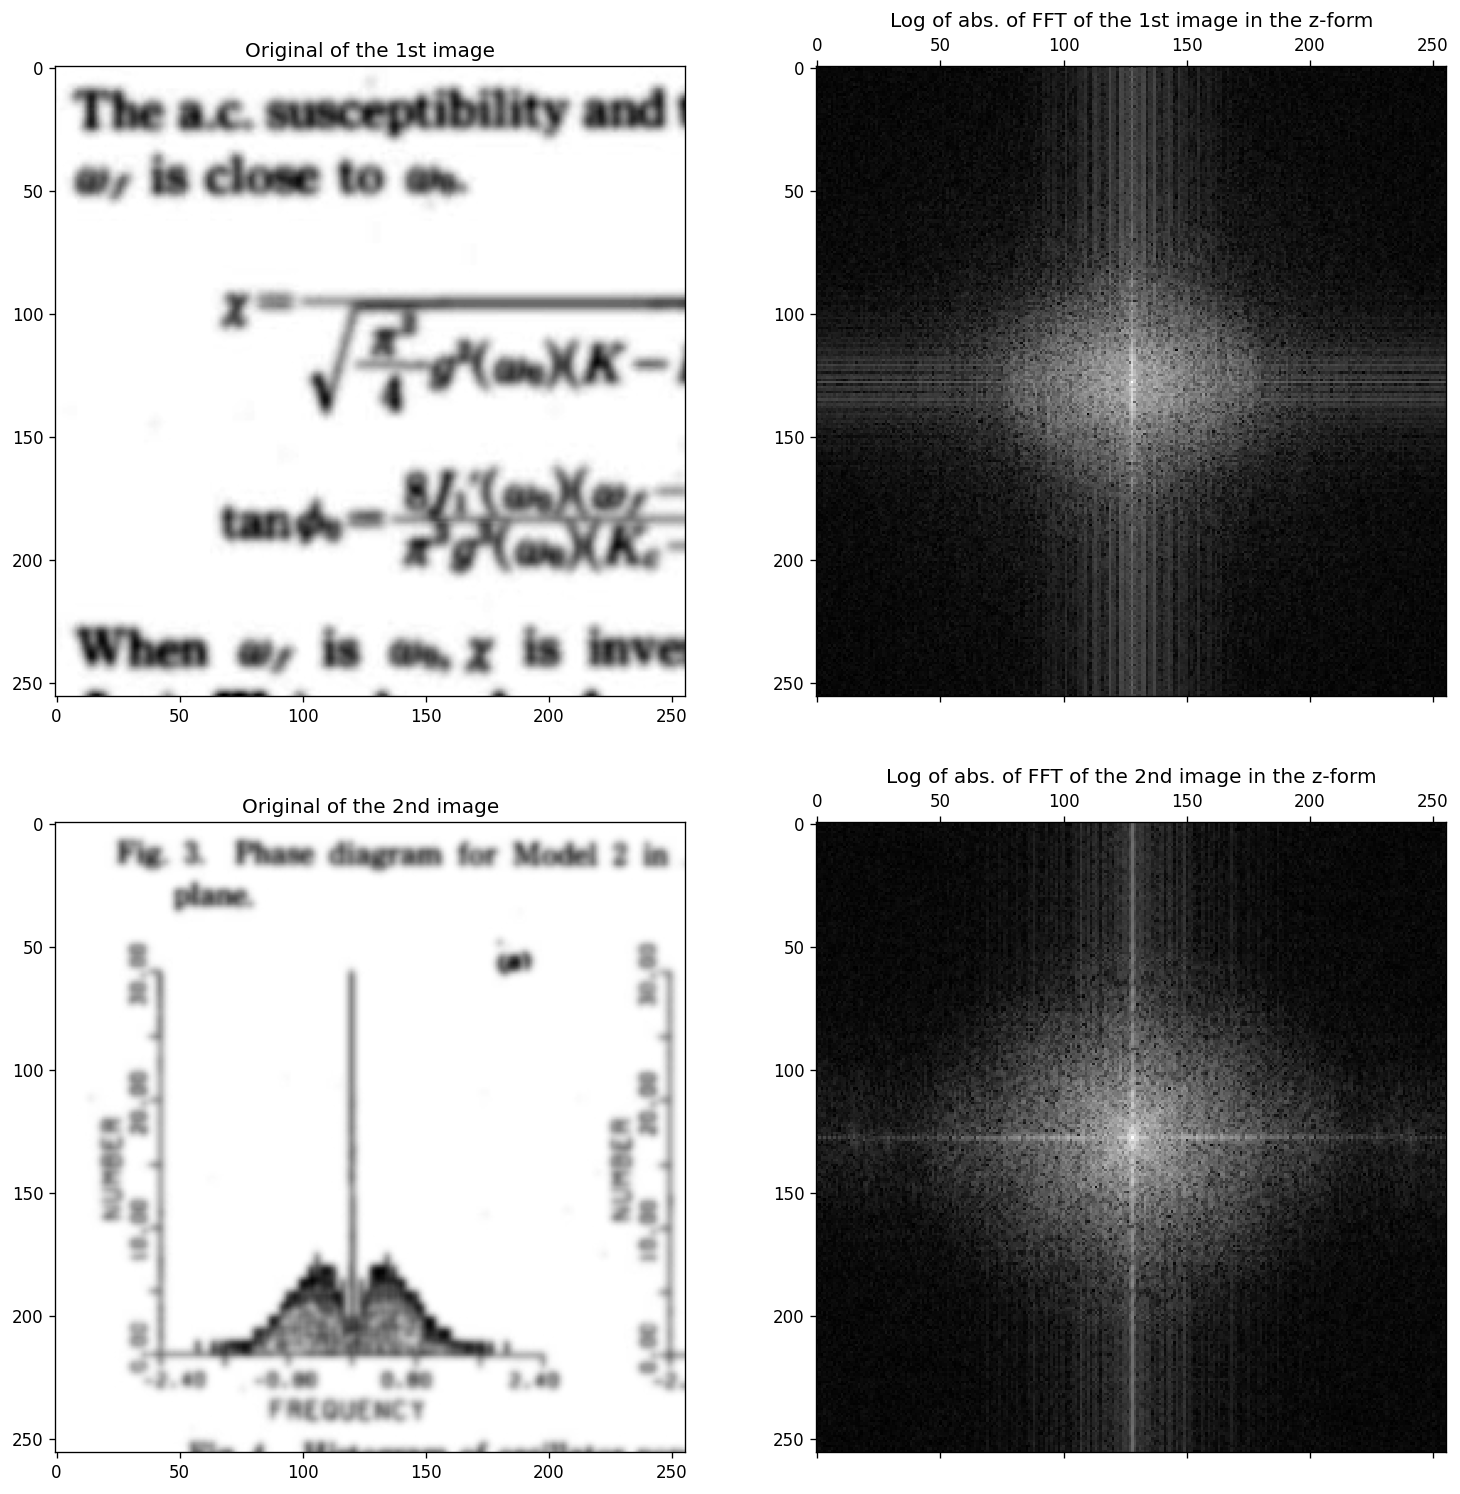

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].matshow(z_1_fft_logabs, cmap='gray')
axs[0, 1].set_title('Log of abs. of FFT of the 1st image in the z-form')
axs[1, 0].imshow(np_2_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].matshow(z_2_fft_logabs, cmap='gray')
axs[1, 1].set_title('Log of abs. of FFT of the 2nd image in the z-form')
plt.show()

Apply the Gaussian homomorphic filter with different $\gamma_H$ and $\gamma_L$ to the 1st image.

In [13]:
# D0 ~ 5%, different gamma and c

s_fft_gshm_1_1 = apply_gs_hom(z_1_fft, 1.5, 0.5, 1, 0.05)
s_fft_gshm_1_2 = apply_gs_hom(z_1_fft, 1.5, 0.5, 5, 0.05)
s_fft_gshm_1_3 = apply_gs_hom(z_1_fft, 2, 0.25, 1, 0.05)
s_fft_gshm_1_4 = apply_gs_hom(z_1_fft, 2, 0.25, 5, 0.05)

In [14]:
# D0 ~ 50%, different gamma and c

s_fft_gshm_2_1 = apply_gs_hom(z_1_fft, 1.5, 0.5, 1, 0.5)
s_fft_gshm_2_2 = apply_gs_hom(z_1_fft, 1.5, 0.5, 5, 0.5)
s_fft_gshm_2_3 = apply_gs_hom(z_1_fft, 2, 0.25, 1, 0.5)
s_fft_gshm_2_4 = apply_gs_hom(z_1_fft, 2, 0.25, 5, 0.5)

In [15]:
s_1_1 = np.abs(get_ifft(s_fft_gshm_1_1))
s_1_2 = np.abs(get_ifft(s_fft_gshm_1_2))
s_1_3 = np.abs(get_ifft(s_fft_gshm_1_3))
s_1_4 = np.abs(get_ifft(s_fft_gshm_1_4))
s_2_1 = np.abs(get_ifft(s_fft_gshm_2_1))
s_2_2 = np.abs(get_ifft(s_fft_gshm_2_2))
s_2_3 = np.abs(get_ifft(s_fft_gshm_2_3))
s_2_4 = np.abs(get_ifft(s_fft_gshm_2_4))

g_1_1 = np.exp(s_1_1)
g_1_2 = np.exp(s_1_2)
g_1_3 = np.exp(s_1_3)
g_1_4 = np.exp(s_1_4)
g_2_1 = np.exp(s_2_1)
g_2_2 = np.exp(s_2_2)
g_2_3 = np.exp(s_2_3)
g_2_4 = np.exp(s_2_4)

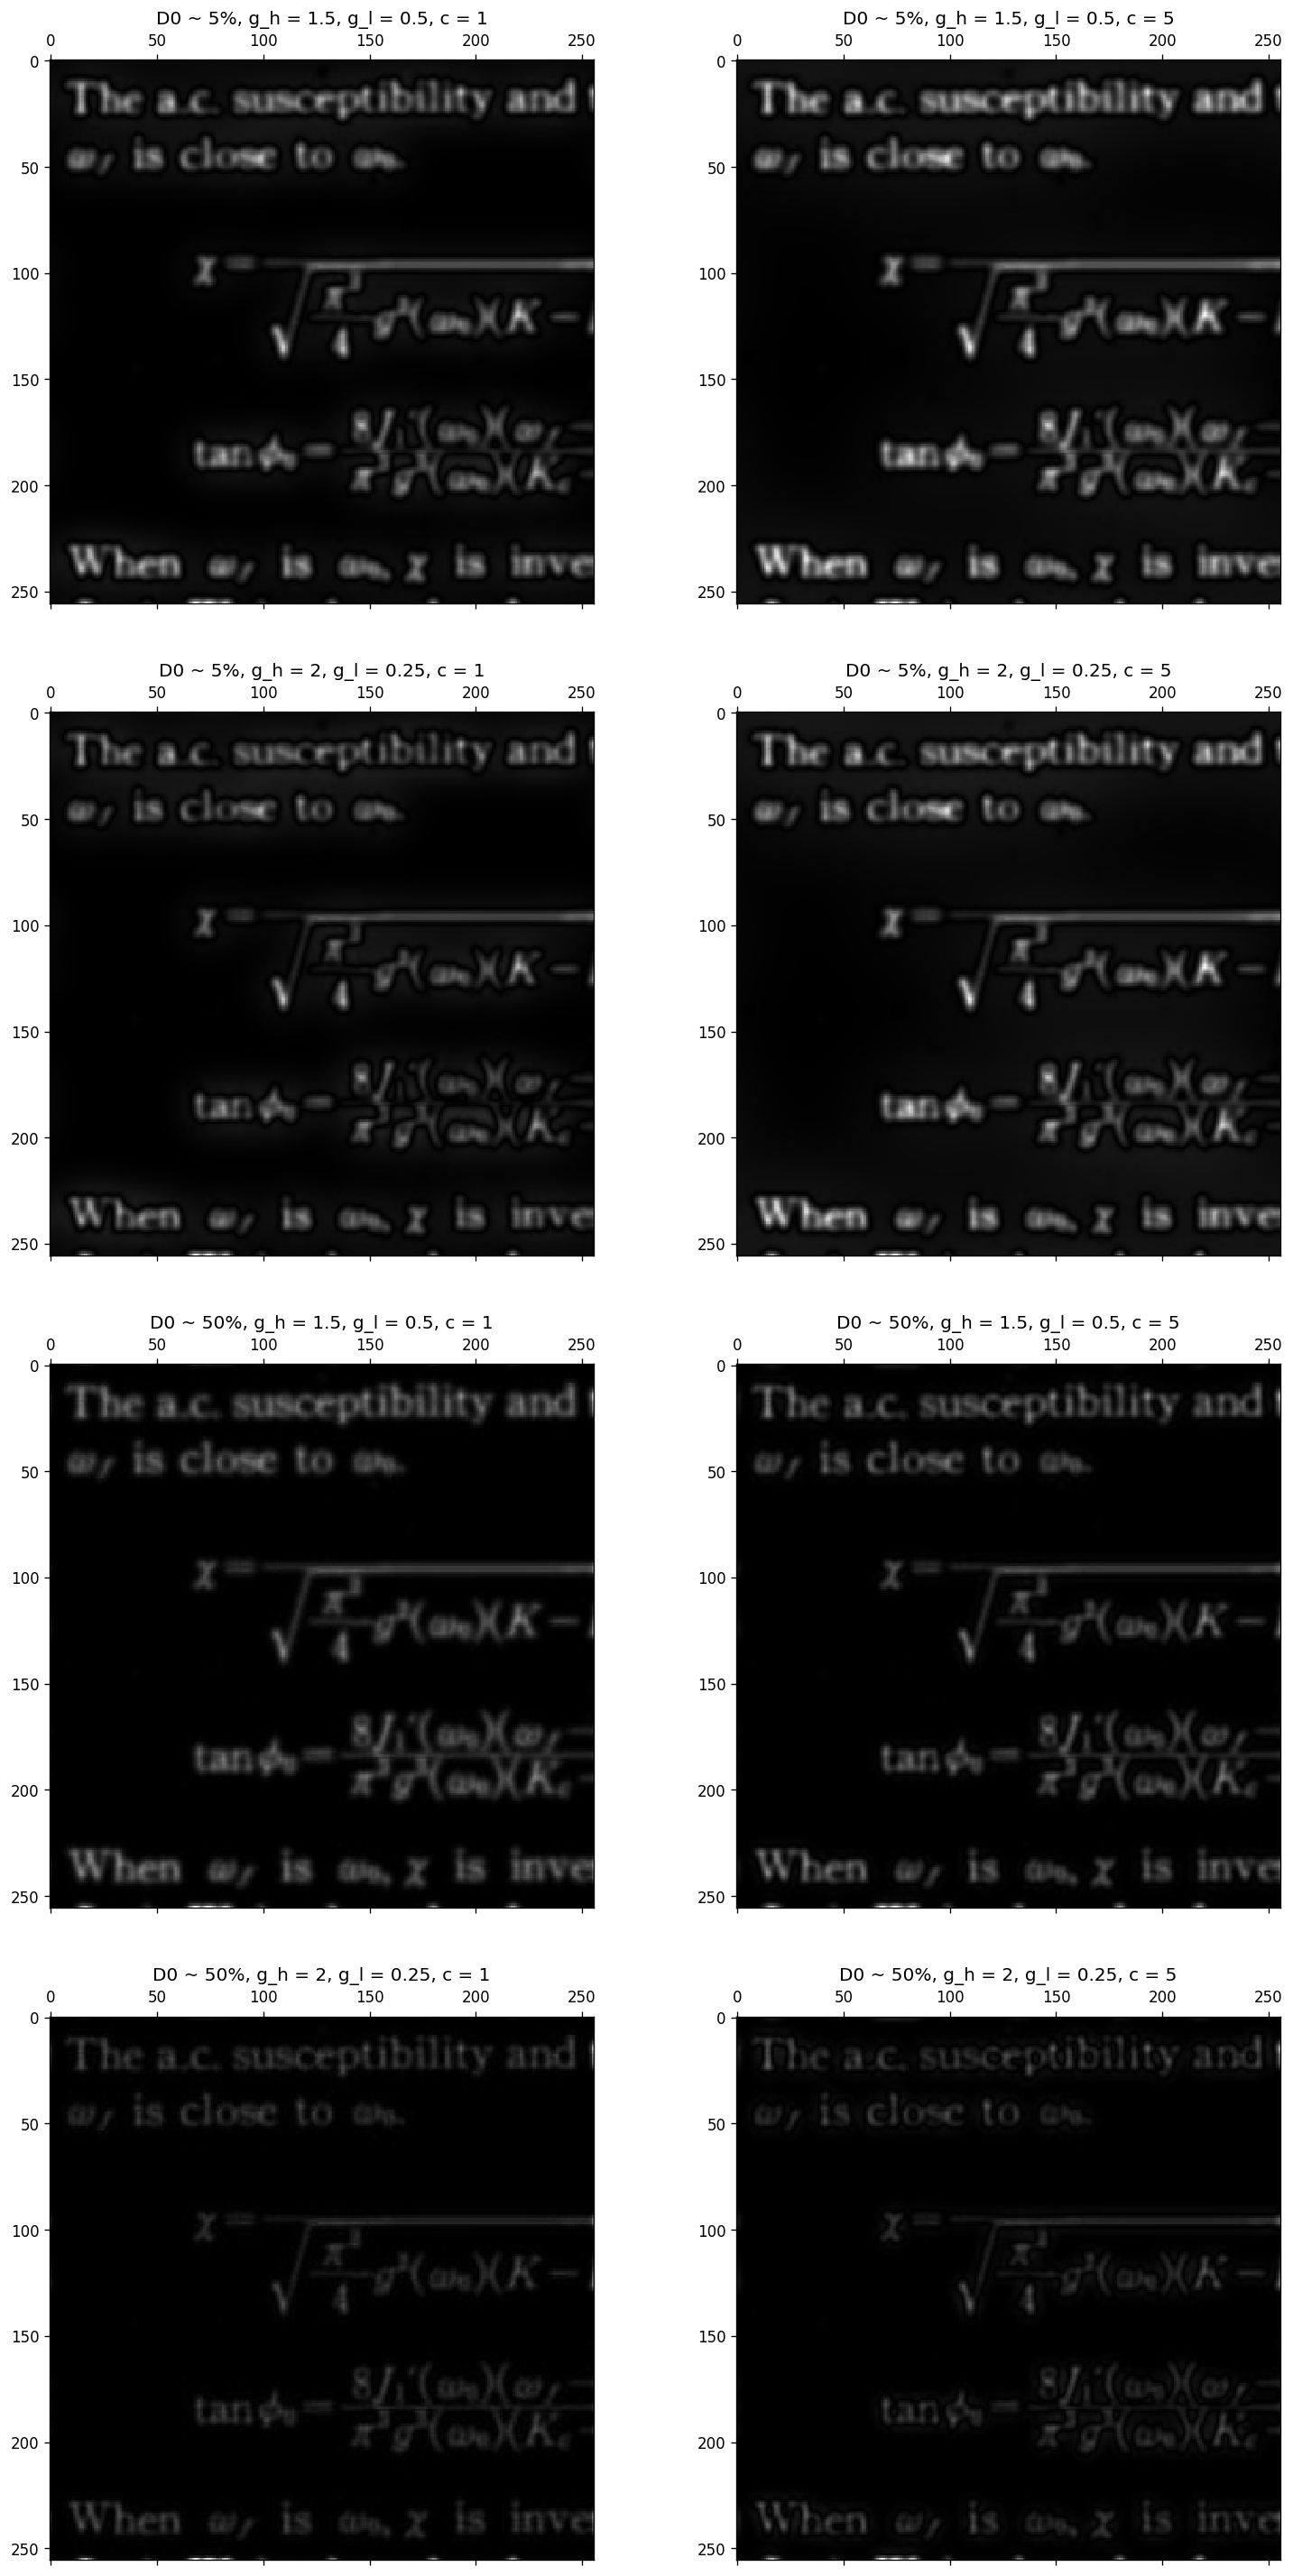

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(15, 30), dpi=120)
axs[0, 0].matshow(g_1_1, cmap='gray')
axs[0, 0].set_title('D0 ~ 5%, g_h = 1.5, g_l = 0.5, c = 1')
axs[0, 1].matshow(g_1_2, cmap='gray')
axs[0, 1].set_title('D0 ~ 5%, g_h = 1.5, g_l = 0.5, c = 5')
axs[1, 0].matshow(g_1_3, cmap='gray')
axs[1, 0].set_title('D0 ~ 5%, g_h = 2, g_l = 0.25, c = 1')
axs[1, 1].matshow(g_1_4, cmap='gray')
axs[1, 1].set_title('D0 ~ 5%, g_h = 2, g_l = 0.25, c = 5')
axs[2, 0].matshow(g_2_1, cmap='gray')
axs[2, 0].set_title('D0 ~ 50%, g_h = 1.5, g_l = 0.5, c = 1')
axs[2, 1].matshow(g_2_2, cmap='gray')
axs[2, 1].set_title('D0 ~ 50%, g_h = 1.5, g_l = 0.5, c = 5')
axs[3, 0].matshow(g_2_3, cmap='gray')
axs[3, 0].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 1')
axs[3, 1].matshow(g_2_4, cmap='gray')
axs[3, 1].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 5')
plt.show()

It seems that the configuration $D_0 \sim 50\%$, $\gamma_H = 2$, $\gamma_L = 0.25$, $c = 1$ allows to obtain the best result.
Let's apply the negative and then the power transformations to the corresponding image.

In [17]:
g_2_3_negpow = np.power((1 - g_2_3/np.max(g_2_3)), 4)

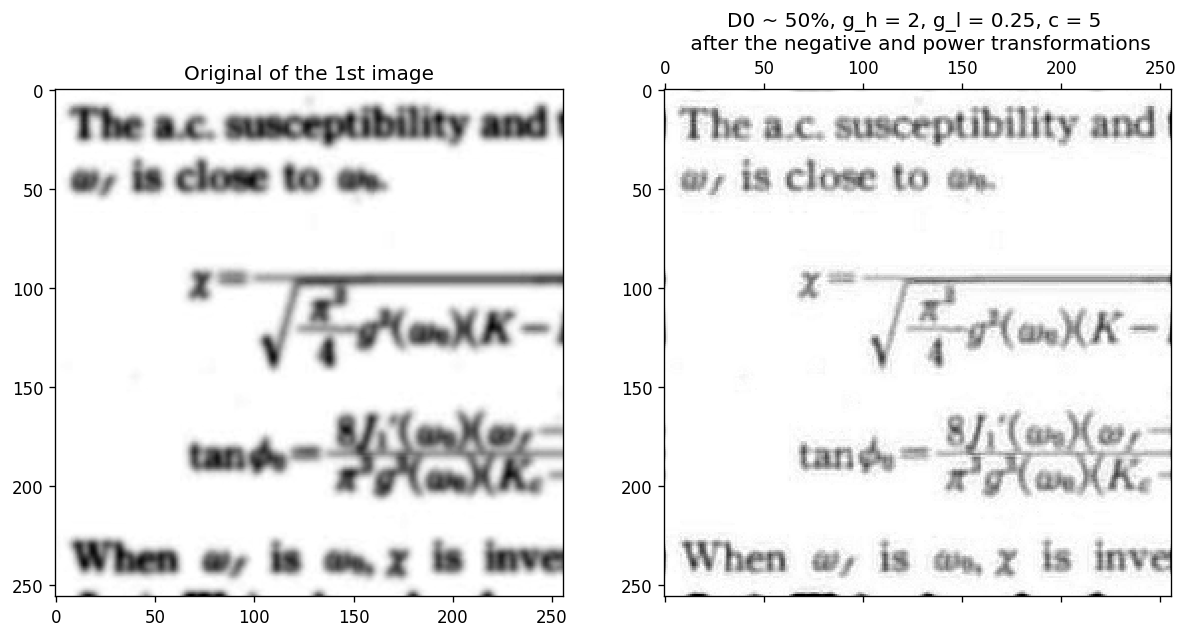

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=120)
axs[0].imshow(np_1_sum, cmap='gray')
axs[0].set_title('Original of the 1st image')
axs[1].matshow(g_2_3_negpow, cmap='gray')
axs[1].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 5 \n after the negative and power transformations')
plt.show()

**Conclusion**: the 1st image is now quite readable after the application of the homomorphic filter (and the negative with the power transformations).

We are now to process the 2nd image in the same way:

In [19]:
# D0 ~ 50%, different gamma and c

s_fft_gshm_3_1 = apply_gs_hom(z_2_fft, 1.5, 0.5, 1, 0.5)
s_fft_gshm_3_2 = apply_gs_hom(z_2_fft, 1.5, 0.5, 5, 0.5)
s_fft_gshm_3_3 = apply_gs_hom(z_2_fft, 2, 0.25, 1, 0.5)
s_fft_gshm_3_4 = apply_gs_hom(z_2_fft, 2, 0.25, 5, 0.5)

In [20]:
s_3_1 = np.abs(get_ifft(s_fft_gshm_3_1))
s_3_2 = np.abs(get_ifft(s_fft_gshm_3_2))
s_3_3 = np.abs(get_ifft(s_fft_gshm_3_3))
s_3_4 = np.abs(get_ifft(s_fft_gshm_3_4))

g_3_1 = np.exp(s_3_1)
g_3_2 = np.exp(s_3_2)
g_3_3 = np.exp(s_3_3)
g_3_4 = np.exp(s_3_4)

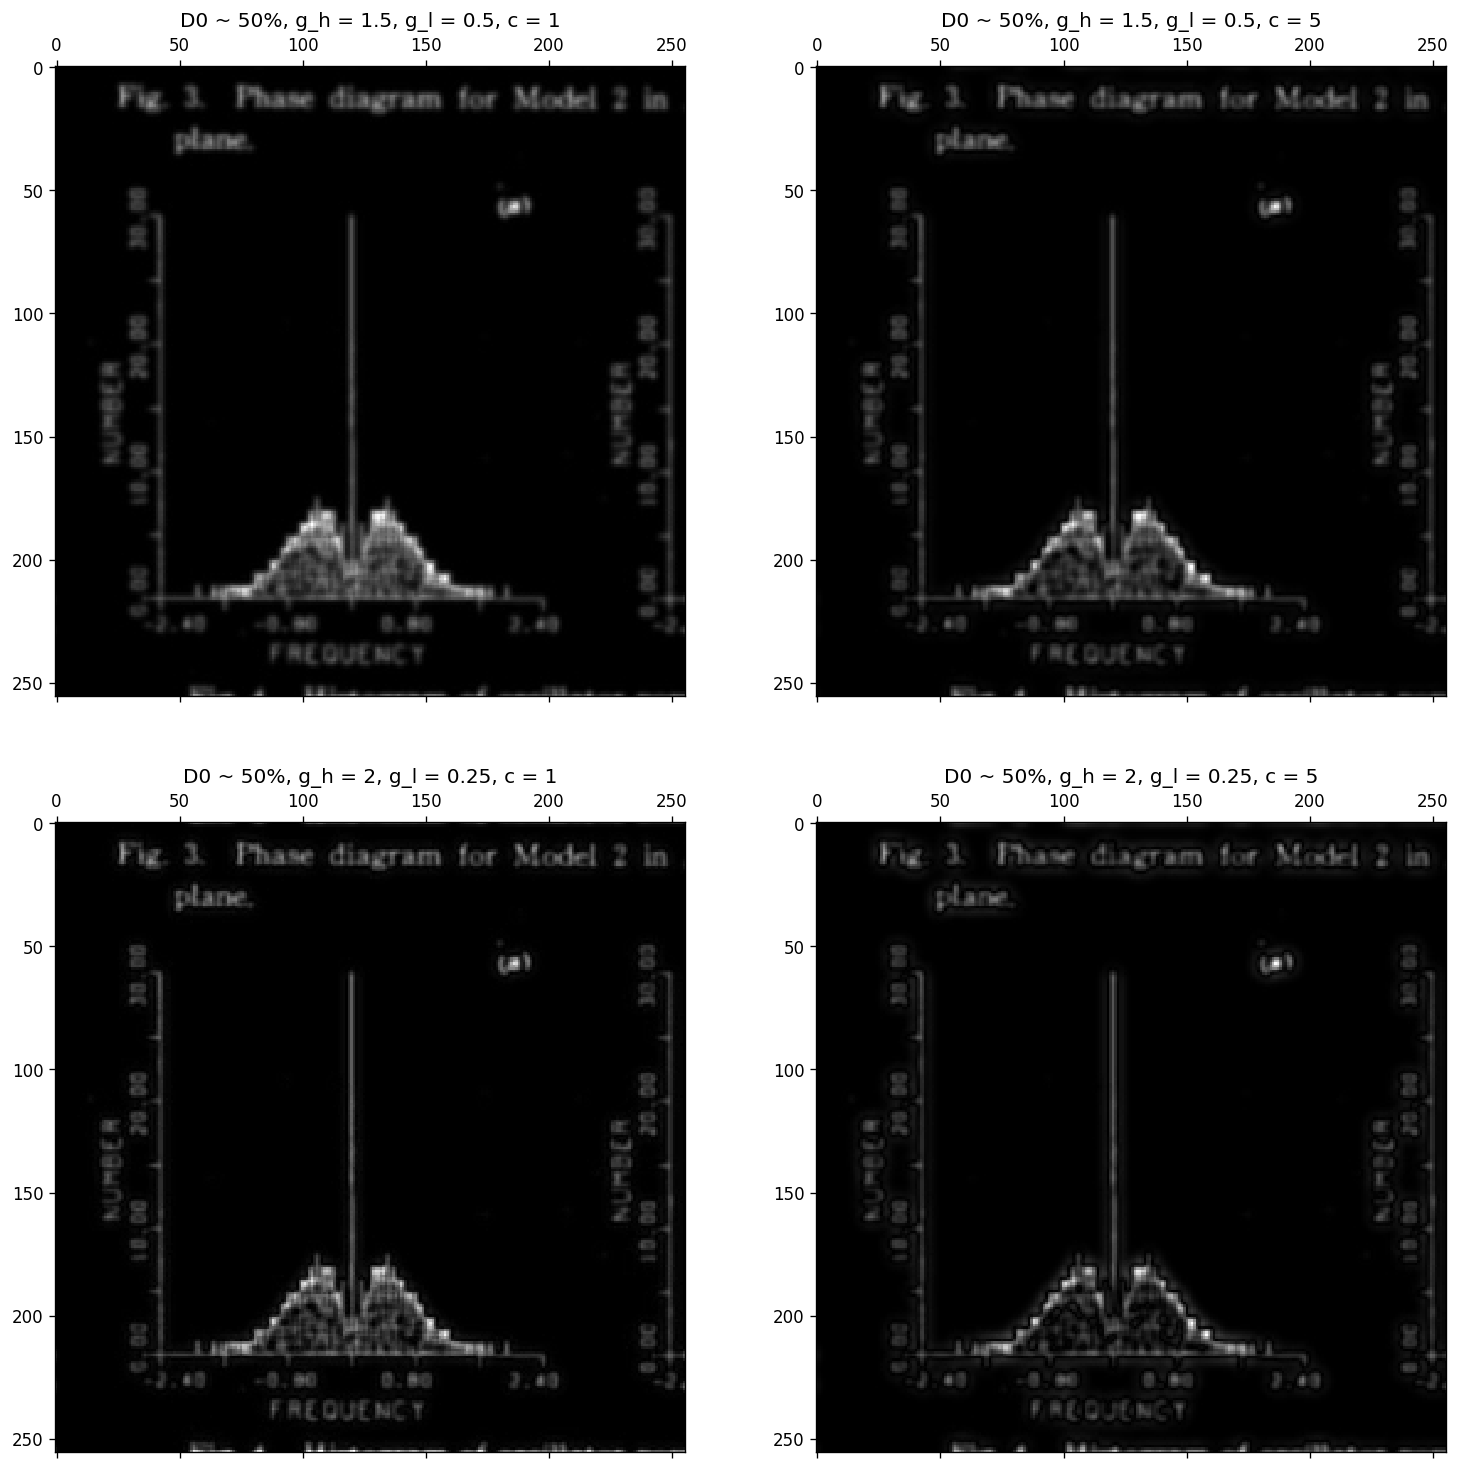

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].matshow(g_3_1, cmap='gray')
axs[0, 0].set_title('D0 ~ 50%, g_h = 1.5, g_l = 0.5, c = 1')
axs[0, 1].matshow(g_3_2, cmap='gray')
axs[0, 1].set_title('D0 ~ 50%, g_h = 1.5, g_l = 0.5, c = 5')
axs[1, 0].matshow(g_3_3, cmap='gray')
axs[1, 0].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 1')
axs[1, 1].matshow(g_3_4, cmap='gray')
axs[1, 1].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 5')
plt.show()

Again, we pick the result obtained with the configuration $D_0 \sim 50\%$, $\gamma_H = 2$, $\gamma_L = 0.25$, $c = 1$ for further processing.

In [22]:
g_3_3_negpow = np.power((1 - g_3_3/np.max(g_3_3)), 2)

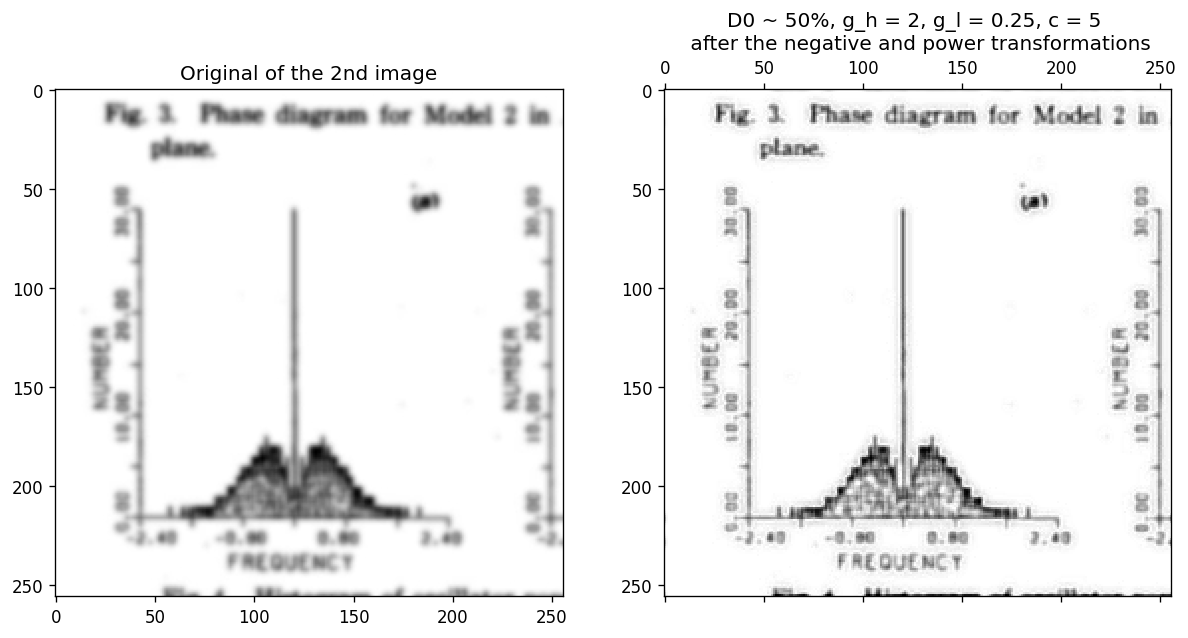

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=120)
axs[0].imshow(np_2_sum, cmap='gray')
axs[0].set_title('Original of the 2nd image')
axs[1].matshow(g_3_3_negpow, cmap='gray')
axs[1].set_title('D0 ~ 50%, g_h = 2, g_l = 0.25, c = 5 \n after the negative and power transformations')
plt.show()

**Conclusion**: the 2nd image is much more readable after the transformations in comparison with the original.